In [1]:
import os
import sys
import time
import h5py
import pygrib
import numpy as np
import netCDF4 as nc
from scipy.interpolate import interp2d
from datetime import datetime, timedelta

sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def norm_precip(x):
    return np.log(x+1)

def norm_rh(x):
    return 2*(x/100 - 0.5)

def norm_t(x):
    return (x-273.15)/20

def norm_u(x):
    return x/10

**Batch gen 2021**

In [4]:
BATCH_dir = '/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/'

year = 2021

size_mrms = 128
size_half = 64
gap = 64 # samples will have at least 5 non-overlap grids on height and width dimensions 
thres_dry = 1.0 # 1.0 mm = rain on that grid
thres_rain_cover = 0.33 # at least 25% of the grids should have rain
thres_land_cover = 0.90 # at least 90% of the grids should stay within land
thres_extreme = 30 # if a grid has 20 mm/hr or above, the sample will bypass "thres_rain_cover"
thres_extreme_cover = 0.10 # if a grid has 20 mm/hr or above, the sample will bypass "thres_rain_cover"

In [5]:
base = datetime(year, 1, 1)
date_list = [base + timedelta(hours=day) for day in range(365*24)]

In [6]:
with h5py.File(save_dir+'MRMS_ERA5_domain.hdf', 'r') as h5io:
    land_mask_MRMS = h5io['land_mask_MRMS'][...]
    elev_MRMS = h5io['elev_MRMS'][...]
    indx = h5io['MRMS_to_ERA5_indx'][...]
    indy = h5io['MRMS_to_ERA5_indy'][...]

In [7]:
elev_MRMS[elev_MRMS<0] = 0
elev_MRMS = elev_MRMS/2000

**Single Profile batches**

In [8]:
x_mrms = 3500
y_mrms = 7000
N_grids = size_mrms*size_mrms
batch_file_name = 'ERA5_y{:04d}_dt{:04d}_i{:04d}_j{:04d}.npy'

In [11]:
x_ERA5 = 361
y_ERA5 = 721

x_lr6 = np.linspace(0, 1, 6)
x_lr7 = np.linspace(0, 1, 7)
x_hr128 = np.linspace(0, 1, 128)

nc_name_t = ERA5_dir+'ERA5_t2m_2021_bottom_layers.nc'
nc_name_u = ERA5_dir+'ERA5_u_2021_bottom_layers.nc'
nc_name_rh = ERA5_dir+'ERA5_rh_2021_bottom_layers.nc'

batch_file_name = 'ERA5_dt{:04d}_i{:04d}_j{:04d}.npy'

data = np.empty((1, size_mrms, size_mrms, 5))

with nc.Dataset(nc_name_t) as ncio_t:
    with nc.Dataset(nc_name_u) as ncio_u:
        with nc.Dataset(nc_name_rh) as ncio_rh:
            # Main section
            for i_dt, dt in enumerate(date_list[:2]):
                dt_str = datetime.strftime(dt, '%Y%m%d-%H%M%S')
                name_ = 'MRMS_MultiSensor_QPE_01H_Pass2_00.00_{}.grib2'.format(dt_str)
                filename = MRMS_dir + name_
                
                if os.path.isfile(filename):
                    with pygrib.open(filename) as grbio:
                        MRMS = grbio[1].values
                    # flip --> lower latitude at the bottom
                    MRMS = np.flipud(MRMS)
            
                    for i_mrms in range(0, x_mrms-size_mrms+gap, gap):
                        for j_mrms in range(0, y_mrms-size_mrms+gap, gap):
                            i0 = i_mrms; i1 = i0 + size_mrms
                            j0 = j_mrms; j1 = j0 + size_mrms
                            patch_ = MRMS[i0:i1, j0:j1]
                            land_mask_ = land_mask_MRMS[i0:i1, j0:j1]

                            r_rain = np.sum(patch_ > thres_dry)/N_grids
                            
                            flag_size = patch_.shape == (size_mrms, size_mrms)
                            flag_rain_cover = r_rain >= thres_rain_cover
                            flag_land_cover = (np.sum(land_mask_)/N_grids) >= thres_land_cover
                            flag_extreme = np.logical_and(np.max(patch_) >= thres_extreme, r_rain >= thres_extreme_cover)
            
                            flag_pass1 = np.logical_and(flag_rain_cover, flag_land_cover)
                            flag_pass2 = np.logical_and(flag_extreme, flag_land_cover)
                            flag_pass_final = np.logical_or(flag_pass1, flag_pass2)
            
                            if flag_size and flag_pass_final:

                                elev_ = elev_MRMS[i0:i1, j0:j1]
                                data[0, ..., 4] = elev_
                                
                                data[0, ..., 0] = patch_
                                i_era = indx[i0:i1, j0:j1]
                                j_era = indy[i0:i1, j0:j1]

                                i_min = np.int(np.min(i_era))
                                i_max = np.int(np.max(i_era))
                                j_min = np.int(np.min(j_era))
                                j_max = np.int(np.max(j_era))

                                data_t = ncio_t['t'][i_dt, -1, i_min:i_max+1, j_min:j_max+1]
                                
                                shape_lr = data_t.shape
                                if shape_lr[0] == 6:
                                    x_ = x_lr6
                                else:
                                    x_ = x_lr7
                                
                                if shape_lr[1] == 6:
                                    y_ = x_lr6
                                else:
                                    y_ = x_lr7
                                
                                interp_obj_t = interp2d(y_, x_, data_t, kind='linear')
                                data[0, ..., 1] = interp_obj_t(x_hr128, x_hr128)

                                data_u = ncio_u['u'][i_dt, -1, i_min:i_max+1, j_min:j_max+1]
                                interp_obj_u = interp2d(y_, x_, data_u, kind='linear')
                                data[0, ..., 2] = interp_obj_u(x_hr128, x_hr128)

                                data_r = ncio_rh['r'][i_dt, -1, i_min:i_max+1, j_min:j_max+1]
                                interp_obj_r = interp2d(y_, x_, data_r, kind='linear')
                                data[0, ..., 3] = interp_obj_r(x_hr128, x_hr128)                      


                                data[0, ..., 0] = norm_precip(data[0, ..., 0])
                                data[0, ..., 1] = norm_t(data[0, ..., 1])
                                data[0, ..., 2] = norm_u(data[0, ..., 2])
                                data[0, ..., 3] = norm_rh(data[0, ..., 3])
                                
                                name_ = BATCH_dir+batch_file_name.format(year, i_dt, i_mrms, j_mrms)
                                print(name_)
                                np.save(name_, data)

/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/ERA5_dt2021_i0000_j0704.npy
/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/ERA5_dt2021_i0000_j0704.npy
/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/ERA5_dt2021_i0000_j0768.npy
/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/ERA5_dt2021_i0000_j0768.npy
/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/ERA5_dt2021_i0000_j0832.npy
/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/ERA5_dt2021_i0000_j0832.npy
/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/ERA5_dt2021_i0000_j0832.npy
/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/ERA5_dt2021_i0000_j0832.npy
/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/ERA5_dt2021_i0000_j0832.npy
/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/ERA5_dt2021_i0000_j0832.npy
/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/ERA5_dt2021_i0000_j0896.npy
/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/ERA5_dt2021_i0000_j0896.npy
/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/ERA5_dt2021_i0000_j0896.npy
/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/ERA5_dt2021_i0000_j0896.npy
/glade/campaign/cisl

In [19]:
data = np.load('/glade/campaign/cisl/aiml/ksha/BATCH_ERA5/ERA5_dt2021_i0001_j1408.npy')

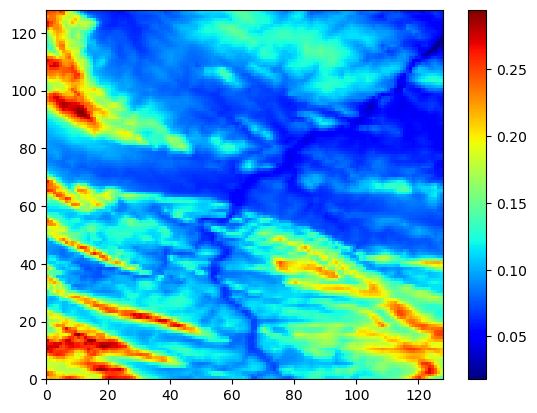

In [25]:
plt.pcolormesh(data[0, ..., 4], cmap=plt.cm.jet)
plt.colorbar()

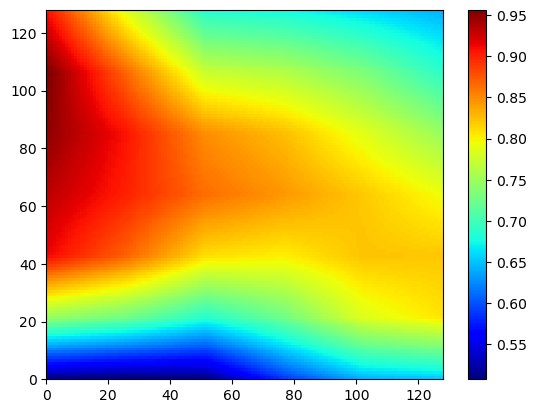

In [129]:
plt.pcolormesh(data[0, ..., 3], cmap=plt.cm.jet)
plt.colorbar()